In [2]:
# ✅ 1. Install dependencies
!pip install -U unsloth accelerate peft bitsandbytes datasets trl sentencepiece


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 15.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 15.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 15.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 14.0 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.4/156.4 MB 15.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 10.1 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 14.2 MB/s eta 0:00:00a 0:00:01
   

In [3]:
# ✅ 2. Imports & Setup
from unsloth import FastLanguageModel
from transformers import TrainingArguments
from trl import SFTTrainer
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import torch

print("GPU Available:", torch.cuda.is_available())


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unsloth: If you want to finetune Gemma 2, upgrade flash-attn to version 2.6.3 or higher!
Newer versions support faster and less memory usage kernels for Gemma 2's attention softcapping!
To update flash-attn, do the below:

pip install --no-deps --upgrade "flash-attn>=2.6.3"
🦥 Unsloth Zoo will now patch everything to make training faster!
GPU Available: True


In [3]:
# ✅ 3. Load and format the dataset
df = pd.read_csv("medquad_tamil.csv").dropna()

# ✅ Format prompt as: ### கேள்வி:\n...\n\n### பதில்:\n...
df["text"] = "### கேள்வி:\n" + df["question_tamil"] + "\n\n### பதில்:\n" + df["answer_tamil"]

# ✅ Split 90:10 and retain all columns
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# ✅ Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))


In [4]:
# ✅ 4. Load model from Unsloth
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "abhinand/gemma-2b-it-tamil-v0.1-alpha",
    max_seq_length = 2048,
    dtype = torch.float16,
    load_in_4bit = True,
)

# Set padding token
tokenizer.pad_token = tokenizer.eos_token


==((====))==  Unsloth 2025.6.2: Fast Gemma patching. Transformers: 4.52.4.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.394 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]


In [5]:
# ✅ 5. Add LoRA (efficient fine-tuning)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    lora_alpha = 32,
    lora_dropout = 0.05,
    bias = "none",
)


Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.6.2 patched 18 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [6]:
# ✅ 6. Preprocessing
def preprocess(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=1024,
    )

tokenized_train = train_dataset.map(preprocess, batched=True)
tokenized_test = test_dataset.map(preprocess, batched=True)


The OrderedVocab you are attempting to save contains holes for indices [1, 2], your vocabulary could be corrupted !


Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14766/14766 [00:05<00:00, 2798.27 examples/s]


The OrderedVocab you are attempting to save contains holes for indices [1, 2], your vocabulary could be corrupted !


Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1641/1641 [00:00<00:00, 2888.97 examples/s]


In [8]:
# ✅ 7. Training Arguments
training_args = TrainingArguments(
    output_dir="tamil_gemma_medqa",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    warmup_steps=50,
    learning_rate=2e-5,
    logging_steps=10,
    num_train_epochs=5,
    fp16=True,
    optim="paged_adamw_8bit",
    report_to="none",  # Set to "wandb" if using Weights & Biases
)


In [9]:
# ✅ 8. Train with SFTTrainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    dataset_text_field="text",
    max_seq_length=1024,
    args=training_args,
)

trainer.train()


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 14,766 | Num Epochs = 5 | Total steps = 4,615
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 19,611,648/2,000,000,000 (0.98% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,0.618300
20,0.411000
30,0.336000
40,0.304300
50,0.301900
60,0.268700
70,0.262600
80,0.233000
90,0.225900
100,0.228800


/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 8a4a4fd4-03d0-4eb3-9db1-e361ce514f3f)') - silently ignoring the lookup for the file config.json in abhinand/gemma-2b-it-tamil-v0.1-alpha.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in abhinand/gemma-2b-it-tamil-v0.1-alpha - will assume that the vocabulary was not modified.
  warnings.warn(


The OrderedVocab you are attempting to save contains holes for indices [1, 2], your vocabulary could be corrupted !


/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error 503 Server Error: Service Temporarily Unavailable for url: https://huggingface.co/abhinand/gemma-2b-it-tamil-v0.1-alpha/resolve/main/config.json - silently ignoring the lookup for the file config.json in abhinand/gemma-2b-it-tamil-v0.1-alpha.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in abhinand/gemma-2b-it-tamil-v0.1-alpha - will assume that the vocabulary was not modified.
  warnings.warn(


The OrderedVocab you are attempting to save contains holes for indices [1, 2], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1, 2], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1, 2], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1, 2], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1, 2], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1, 2], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1, 2], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1, 2], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [

TrainOutput(global_step=4615, training_loss=0.14329929647569667, metrics={'train_runtime': 10797.6511, 'train_samples_per_second': 6.838, 'train_steps_per_second': 0.427, 'total_flos': 9.079016718650573e+17, 'train_loss': 0.14329929647569667})

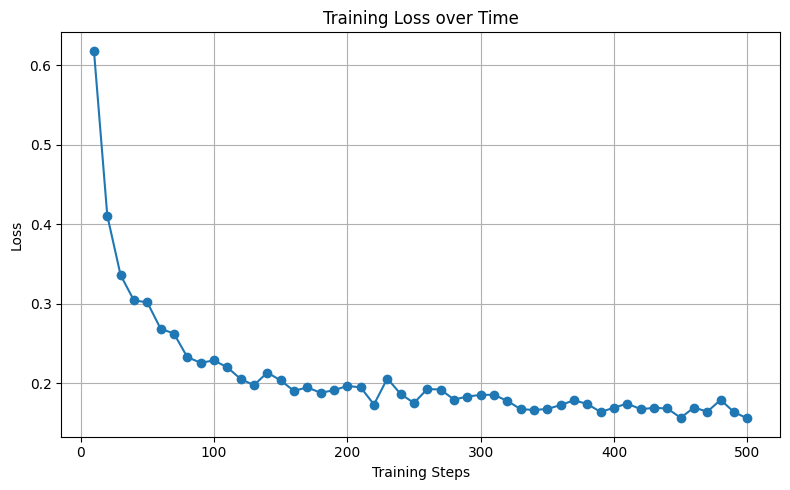

In [2]:
import json
import matplotlib.pyplot as plt

# Replace with the path to your trainer_state.json
state_path = "tamil_gemma_medqa/checkpoint-500/trainer_state.json"

with open(state_path) as f:
    state = json.load(f)

steps = []
losses = []

for log in state["log_history"]:
    if "loss" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# ✅ 9. Save the model
trainer.model.save_pretrained("tamil_gemma_finetuned_medqa")
tokenizer.save_pretrained("tamil_gemma_finetuned_medqa")


The OrderedVocab you are attempting to save contains holes for indices [1, 2], your vocabulary could be corrupted !


('tamil_gemma_finetuned_medqa/tokenizer_config.json',
 'tamil_gemma_finetuned_medqa/special_tokens_map.json',
 'tamil_gemma_finetuned_medqa/tokenizer.model',
 'tamil_gemma_finetuned_medqa/added_tokens.json',
 'tamil_gemma_finetuned_medqa/tokenizer.json')

In [7]:
!pip install bert-score


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from bert_score import score
from tqdm import tqdm
import torch
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="tamil_gemma_finetuned_medqa",
    max_seq_length=2048,
    dtype=torch.float16,
    load_in_4bit=True
)

# ✅ Prepare for evaluation
generated_answers = []
reference_answers = []

model.eval()

for item in tqdm(test_dataset):
    question = item["question_tamil"]
    reference = item["answer_tamil"]

    prompt = f"### கேள்வி:\n{question}\n\n### பதில்:\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False
        )


    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract generated answer part
    if "### பதில்:\n" in decoded:
        answer = decoded.split("### பதில்:\n")[-1].strip()
    else:
        answer = decoded.strip()

    generated_answers.append(answer)
    reference_answers.append(reference)


==((====))==  Unsloth 2025.6.2: Fast Gemma patching. Transformers: 4.52.4.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.394 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


abhinand/gemma-2b-it-tamil-v0.1-alpha does not have a padding token! Will use pad_token = <pad>.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1641/1641 [3:15:23<00:00,  7.14s/it]


In [13]:
from bert_score import score

P, R, F1 = score(generated_answers, reference_answers, lang="ta")  # ta = Tamil

print(f"Precision: {P.mean().item():.4f}")
print(f"Recall:    {R.mean().item():.4f}")
print(f"F1 Score:  {F1.mean().item():.4f}")


Precision: 0.6616
Recall:    0.6493
F1 Score:  0.6543


In [14]:
import pandas as pd

# Convert tensors to numpy
P = P.numpy()
R = R.numpy()
F1 = F1.numpy()

# Report average
print(f"\n✅ BERTScore Precision: {P.mean():.4f}")
print(f"✅ BERTScore Recall:    {R.mean():.4f}")
print(f"✅ BERTScore F1:        {F1.mean():.4f}")

# Optional: Save individual results
results_df = pd.DataFrame({
    "Generated Answer": generated_answers,
    "Reference Answer": reference_answers,
    "Precision": P,
    "Recall": R,
    "F1 Score": F1
})

results_df.to_csv("tamil_bertscore.csv", index=False)
print("✅ Saved: tamil_bertscore.csv")



✅ BERTScore Precision: 0.6616
✅ BERTScore Recall:    0.6493
✅ BERTScore F1:        0.6543
✅ Saved: tamil_bertscore.csv
